In [1]:
import pandas as pd
import os
import numpy as np
from IPython.display import display
%matplotlib inline

master_df = pd.read_csv('./baseballdatabank-2017.1/core/Master.csv')
salaries_df = pd.read_csv('./baseballdatabank-2017.1/core/salaries.csv')

# Introduction

I chose to use the baseball data bank for this analysis. After some initial exploration of the `master`, `fielding`, `pitching`, `batting`, and `salaries` table I decided to focus on the `master` and `salaries` tables. I've always been intererested in labor economics so I decided that it would be fun to look at how economic opportunity changes with pro baseball players' ages.

The following sections detail the questions I decided to explore and their analysis.

### How old are players when they go pro?

The age of a player going pro can be represented as their `debut - birthdate`. The data for both is contained in the table but I needed to do a little munging to get at them.

I decided to start with the debut, which was given as a string and simply had to be converted to a datetime.

In [2]:
master_df['debut'] = pd.to_datetime(master_df['debut'])

Next I went looking for birthdates, which were a little more tricky. The `year`, `month`, and `day` of the birthdate were stored seperately, so I renamed some columns to fit the built in `pd.to_datetime` function and created a combined `birthDate`. 

In [3]:
master_df['year'] = master_df['birthYear']
master_df['month'] = master_df['birthMonth']
master_df['day'] = master_df['birthDay']
master_df['birthDate'] = pd.to_datetime(master_df[['year', 'month', 'day']])

Now that I had a working `birthdate` and `debut` I decided to subtract the two to get their players' `ageAtDebut`. Because any players that were missing `debut` or `birthDate` data would result in NaN values I first filled them with `0`, but that results in a bunch of 0 ages which weren't very useful so I filtered them out in the final analysis.

The age is initally calcualted in days then divided by 365 to approximate years.

count    18473.000000
mean        24.338905
std          2.752478
min         15.873973
25%         22.501370
50%         24.139726
75%         25.890411
max         42.567123
Name: ageAtDebut, dtype: float64

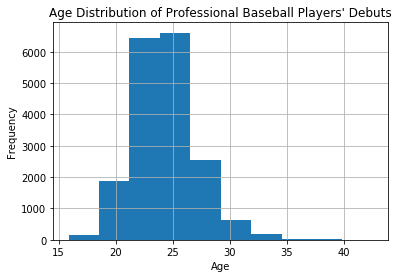

In [4]:
master_df['ageAtDebut'] = (master_df['debut'] - master_df['birthDate']).fillna(0)
master_df['ageAtDebut'] = (master_df['ageAtDebut']/ (np.timedelta64(1, 'D')*365))
ages = master_df['ageAtDebut'][master_df['ageAtDebut'] > 0]
ages_hist = ages.hist()
ages_hist.set_xlabel("Age")
ages_hist.set_ylabel("Frequency")
ages_hist.set_title("Age Distribution of Professional Baseball Players' Debuts")
display(ages_hist)
ages.describe()

From the data above we see that the average age of a player to go pro is when they are 24 years old. The youngest pro ever was just 15 and the oldest was 42. Most players go pro in their 20's.

A limitation of this data is that 632 of the 19105 entries are missing the data necessary to calculate their age at the time of the debut.

In [5]:
playerCount = len(master_df)
debutAgeNulls = playerCount - len(ages)

print 'Number of Records: ' + str(playerCount)
print 'Number of Records w/ Errors: ' + str(debutAgeNulls)

Number of Records: 19105
Number of Records w/ Errors: 632


### How does average salary change with age?

Now that we know how old players are when they go pro, I decided to explore how the earning of players changes on average with age.

To perform this analysis I needed to combine `salary` data from the `salaries` table with `age`. As with the age at debut analysis I knew that I would need to subtract two dates -- in this case, birthdate from the year of the player's salary data. I already had a datetime representing birthdays, so this time I just had to convert the string representing the salary year to a datetime and again filtered out any 0 ages that were caused by missing data.

Note that ages are represented as truncated integer year. The age is initally calcualted in days then divided by 365 to approximate years.

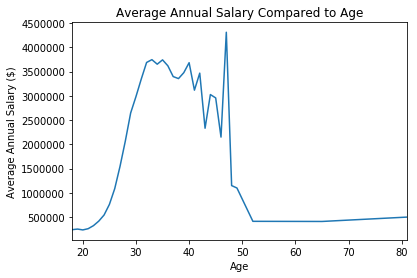

In [6]:
ages_df = pd.merge(salaries_df, master_df, how='left', left_on='playerID', right_on='playerID')
ages_df['age'] = (pd.to_datetime(ages_df['yearID'], format='%Y') - ages_df['birthDate'])
ages_df['age'] = (ages_df['age'].fillna(0) / (np.timedelta64(1, 'D')*365)).astype(int)
ages_plot = ages_df[ages_df['age']>0].groupby(['age'])['salary'].mean().plot()
ages_plot.set_xlabel("Age")
ages_plot.set_ylabel("Average Annual Salary ($)")
ages_plot.set_title("Average Annual Salary Compared to Age")

It appears that there's an expontential increase in average salary for players in their 20's as they age and then it starts to peak in their early 30's which continues on through their 40's and has greatly decreased by their 50's. There's an large spike in the late 40's that actually constitutes the largest average salary. I decided not to explore the cause of the peak, but it would be an interesting point of further study. I hypothesize that this peak is driven by very high paid outliers.

Out of the 26428 records, there were only 8 entries that have erroneous age data -- all of these are due to missing birthdates. There are only 2 records with a salary of $0. A major limitation of the data is it only includes salary data for 5155 of the 19105 players in the dataset. It should also be noted that this is an average across different years and the salary data is not normalized. Ideally dollar amounts would be normalized to a particular year or each year would be comapred independently

In [7]:
salaryCount = len(salaries_df)
salaryAgeNulls = (pd.to_datetime(ages_df['yearID'], format='%Y') - ages_df['birthDate']).isnull().sum()
uniquePlayerSalaries = ages_df['playerID'].unique()


print 'Number of Records: ' + str(salaryCount)
print 'Number of Records w/ Missing Ages: ' + str(salaryAgeNulls)
print 'Salaries of $0: ' + str(len(ages_df[ages_df['salary'] ==0]))
print 'Players with Salary Data: ' + str(len(uniquePlayerSalaries))

Number of Records: 26428
Number of Records w/ Missing Ages: 8
Salaries of $0: 2
Players with Salary Data: 5155


### How does birth month change average salary?

I once read that for hockey player's there's a strong correlation between star players and the month in which they were born. The hypothesized explanation was that it was caused by age cutoffs for childrens sports leagues. Depending on when they were born, the oldest team members would be as much as a year older than their peers who were the same 'age'. At early ages, that short developmental advantage is actually a large competitive advantage and gives those students a compounding effect over their lifetimes. I was curious if the same type of trend would show up in the baseball data.

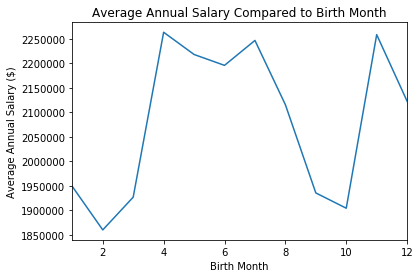

In [8]:
birthmonth_df = pd.merge(salaries_df, master_df, how='left', left_on='playerID', right_on='playerID')
birthmonth_salaries = birthmonth_df.groupby(['birthMonth'])['salary'].mean()
birthmonth_plot = birthmonth_salaries.plot()
birthmonth_plot.set_xlabel("Birth Month")
birthmonth_plot.set_ylabel("Average Annual Salary ($)")
birthmonth_plot.set_title("Average Annual Salary Compared to Birth Month")

It doesn't appear that there's a clear trend in the birth-month and the average salary of a player. The winter months are lower on average except for November, which is actually quite high. From this data, I don't think it's approriate to conclude that there's a clear trend in certain birthmonths leading to higher salaries. Again, I hypothesize that this data might be heavily skewed by high paid outliers, which might be a good topic for future exploration.

A major limitation of the data is it only includes salary data for 5155 of the 19105 players in the dataset. A major limitation of the data is it only includes salary data for 5155 of the 19105 players in the dataset. It should also be noted that this is an average across different years and the salary data is not normalized. Ideally dollar amounts would be normalized to a particular year or each year would be comapred independently Only 8 of the salaries are missing an associated birth month.

In [9]:
birthMonthCount = len(birthmonth_df)
birthMonthNulls = (birthmonth_df['birthMonth']).isnull().sum()

print 'Number of Records: ' + str(birthMonthCount)
print 'Number of Records w/ Errors: ' + str(birthMonthNulls)

Number of Records: 26428
Number of Records w/ Errors: 8


# Appendix

The following section contains explory information for the two tables used in this analysis. They are provided for reference and to illustrate the nature of the underlying data.

In [10]:
print len(master_df)
display(master_df.head(1))
master_df.describe()

19105


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,throws,debut,finalGame,retroID,bbrefID,year,month,day,birthDate,ageAtDebut
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,R,2004-04-06,2015-08-23,aardd001,aardsda01,1981.0,12.0,27.0,1981-12-27,22.290411


,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height,year,month,day,ageAtDebut
count,18973.000000,18803.000000,18656.000000,9441.000000,9440.000000,9439.000000,18251.000000,18320.000000,18973.000000,18803.000000,18656.000000,19105.000000
mean,1931.435356,6.629474,15.614816,1964.287364,6.483581,15.569552,186.375596,72.273799,1931.435356,6.629474,15.614816,23.533766
std,41.555514,3.468103,8.750216,31.808030,3.529655,8.779552,21.524765,2.603904,41.555514,3.468103,8.750216,5.125861
min,1820.000000,1.000000,1.000000,1872.000000,1.000000,1.000000,65.000000,43.000000,1820.000000,1.000000,1.000000,0.000000
25%,1895.000000,4.000000,8.000000,1942.000000,3.000000,8.000000,170.000000,71.000000,1895.000000,4.000000,8.000000,22.295890
50%,1937.000000,7.000000,16.000000,1967.000000,6.000000,15.000000,185.000000,72.000000,1937.000000,7.000000,16.000000,24.041096
75%,1969.000000,10.000000,23.000000,1990.000000,10.000000,23.000000,200.000000,74.000000,1969.000000,10.000000,23.000000,25.813699
max,1996.000000,12.000000,31.000000,2017.000000,12.000000,31.000000,320.000000,83.000000,1996.000000,12.000000,31.000000,42.567123


In [11]:
print len(salaries_df)
display(salaries_df.head(1))
salaries_df.describe()

26428


,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000


,yearID,salary
count,26428.000000,2.642800e+04
mean,2000.878727,2.085634e+06
std,8.909314,3.455348e+06
min,1985.000000,0.000000e+00
25%,1994.000000,2.947020e+05
50%,2001.000000,5.500000e+05
75%,2009.000000,2.350000e+06
max,2016.000000,3.300000e+07
